In [ ]:
# pip install py3Dmol
# pip install biopython pandas scikit-learn
# pip install requests

/Users/glydelfornan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[
  {
    "entryId": "AF-P00520-F1",
    "gene": "Abl1",
    "sequenceChecksum": "BD48ADE8557AE95C",
    "sequenceVersionDate": "2005-02-15",
    "uniprotAccession": "P00520",
    "uniprotId": "ABL1_MOUSE",
    "uniprotDescription": "Tyrosine-protein kinase ABL1",
    "taxId": 10090,
    "organismScientificName": "Mus musculus",
    "uniprotStart": 1,
    "uniprotEnd": 1123,
    "uniprotSequence": "MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTIYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVSAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKRGTRGGAGSMLQAPELPTKTRTCRRAAEQKDAPDTPELLHTKGLGESDALDSEPAVSPLLPRKERGPPDGSLNEDERLLPRDRKTN

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

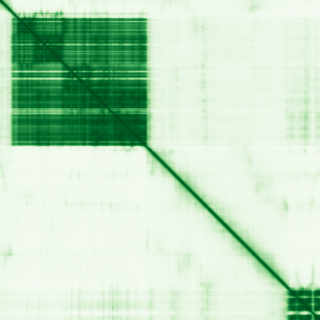

In [1]:
#@title ##1.&nbsp; Get predicted model from AFDB for an UniProt accession
import requests, json

#@markdown This block will retrieve the data for a UniProt accession and will display the 3D structure with the PAE.
UniProt_accession = "P00520" #@param {type:"string"}
#@markdown Note: For visualising structures with interactive PAE viewer, visist the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/api-docs)

import py3Dmol
import requests
from IPython.display import display, Image
import json

def visualize_protein(uniprot_accession, color="lDDT"):
    # Function to retrieve protein information by UniProt accession
    def get_protein(uniprot_accession):
        api_endpoint = "https://alphafold.ebi.ac.uk/api/prediction/"
        url = f"{api_endpoint}{uniprot_accession}"  # Construct the URL for API

        try:
            # Use a timeout to handle potential connection issues
            response = requests.get(url, timeout=10)

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                result = response.json()
                return result
            else:
                # Raise an exception for better error handling
                response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")

    # Function to show protein structure and image
    def show_structure_and_image(pdb_url, image_url, color):
        # Retrieve the PDB data from the URL
        pdb_data = requests.get(pdb_url).text

        # Create a 3Dmol.js view
        view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)

        # Add the PDB data to the view
        view.addModel(pdb_data, 'pdb')

        # Set style based on color parameter
        if color == "lDDT":
            view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
        elif color == "rainbow":
            view.setStyle({'cartoon': {'color': 'spectrum'}})

        # Zoom to the structure
        view.zoomTo()

        # Display the 3D structure
        display(view)

        # Retrieve and display the PNG image
        image_data = requests.get(image_url).content
        display(Image(data=image_data))


######
    protein_info = get_protein(uniprot_accession)

    if protein_info:
        # Use json.dumps with indent parameter to print formatted JSON
        print(json.dumps(protein_info, indent=2))

        # Extract PDB and PNG URLs
        pdb_url = protein_info[0].get('pdbUrl')
        image_url = protein_info[0].get('paeImageUrl')

        if pdb_url and image_url:
            # Show the protein structure and PNG image side by side
            show_structure_and_image(pdb_url, image_url, color)
        else:
            print("Failed to retrieve PDB or PNG URLs.")
    else:
        print("Failed to retrieve protein information.")

# Example: Replace 'P00520' with the desired UniProt accession
visualize_protein(UniProt_accession)

In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from Bio.PDB import PDBParser

def fetch_pdb_file(url: str, filename: str):
    """Download PDB file from URL."""
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded {filename}")

def parse_coordinates(pdb_file: str):
    """Parse the PDB file and extract C-alpha atom coordinates."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Extract C-alpha coordinates
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                # Select only C-alpha atoms
                if "CA" in residue:
                    atom = residue["CA"]
                    coords.append(atom.coord)
                    
    return np.array(coords)

def perform_pca_on_structure(coords: np.ndarray) -> pd.DataFrame:
    """Apply PCA on 3D coordinates and return a DataFrame of PCA components."""
    pca = PCA(n_components=3)  # 3 components to retain spatial information
    pca_coords = pca.fit_transform(coords)
    
    # Create a DataFrame with PCA results
    pca_df = pd.DataFrame(pca_coords, columns=["PC1", "PC2", "PC3"])
    return pca_df

uniprot_id = "P00520"
pdb_url = "https://alphafold.ebi.ac.uk/files/AF-P00520-F1-model_v4.pdb"
pdb_filename = f"{uniprot_id}.pdb"

fetch_pdb_file(pdb_url, pdb_filename)
coords = parse_coordinates(pdb_filename)
pca_df = perform_pca_on_structure(coords)
print(pca_df)
# coords

Downloaded P00520.pdb
            PC1        PC2        PC3
0    -15.409721  12.719034  33.874191
1    -17.261576  10.201055  31.536585
2    -19.347610   8.889450  34.527416
3    -16.059143   7.546200  36.106804
4    -14.924013   5.799694  32.854103
...         ...        ...        ...
1118  44.085293  -5.820835  -3.582429
1119  41.562698  -2.949150  -4.260033
1120  43.335808  -2.098992  -7.593311
1121  46.858997  -2.187770  -5.976512
1122  45.643898   0.487788  -3.465653

[1123 rows x 3 columns]


# Trials

In [15]:
import requests
import pandas as pd

def extract_helical_description(uniprot_id):
    # Send a request to the UniProt API for a single UniProt ID
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error fetching data for {uniprot_id}")
        return None  # Handle the case where the API request fails
    
    data = response.json()
    
    # Extracting the relevant information from the JSON response
    tm_regions = []
    
    # Iterate through features to extract the required "Transmembrane" helical regions
    for feature in data.get('features', []):
        if feature.get('type') == 'Transmembrane' and 'Helical' in feature.get('description', ''):
            # Extract start and end from the description (e.g., "Helical; Name=1")
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            tm_regions.append((start, end))
    
    return tm_regions

def create_dataframe(uniprot_ids):
    # Initialize a list to store data rows
    data = []
    
    # Loop through each UniProt ID and extract its data
    for uniprot_id in uniprot_ids:
        tm_regions = extract_helical_description(uniprot_id)
        
        if tm_regions is not None:
            # Flatten the list of regions into separate columns
            row = [uniprot_id]
            for start, end in tm_regions:
                row.append(start)
                row.append(end)
            
            # If there are fewer regions than the max, pad with None/NaN
            max_tm = 7  # Adjust this if you have a higher number of regions
            while len(row) < (1 + max_tm * 2):  # Only 2 columns per region: Start and End
                row.append(None)  # Adding None for missing regions
            
            data.append(row)
    
    # Create a DataFrame
    column_names = ['primaryAccession']
    
    # Add "TM X Start" and "TM X End" columns dynamically based on the number of regions
    max_tm = 7  # Adjust this if you have a higher number of regions
    for i in range(max_tm):
        column_names.append(f'TMH {i+1} Start')
        column_names.append(f'TMH {i+1} End')
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=column_names)
    
    return df

# Example usage:
uniprot_ids = ['P07550', 'Q5VW38', 'P30542']  # List of UniProt IDs to process
df = create_dataframe(uniprot_ids)
df

,primaryAccession,TMH 1 Start,TMH 1 End,TMH 2 Start,TMH 2 End,TMH 3 Start,TMH 3 End,TMH 4 Start,TMH 4 End,TMH 5 Start,TMH 5 End,TMH 6 Start,TMH 6 End,TMH 7 Start,TMH 7 End
0,P07550,35,58,72,95,107,129,151,174,197,220,275,298,306,329
1,Q5VW38,264,284,294,314,338,358,369,389,403,423,499,519,525,544
2,P30542,11,33,47,69,81,102,124,146,177,201,236,259,268,292


In [26]:
import os
import requests
import json
import py3Dmol
from IPython.display import display, Image
from Bio.PDB import PDBParser

# Function to fetch and download the PDB file
def fetch_pdb_file(url: str, filename: str):
    """Download PDB file from URL."""
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded PDB file for {filename}")

# Function to parse the PDB file and extract C-alpha atom coordinates
def parse_coordinates(pdb_file: str):
    """Parse the PDB file and extract C-alpha atom coordinates."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Extract C-alpha coordinates
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                # Select only C-alpha atoms
                if "CA" in residue:
                    atom = residue["CA"]
                    coords.append(atom.coord)
                    
    return coords

# Function to retrieve protein information from the UniProt API
def get_protein(uniprot_accession):
    """Retrieve protein information from UniProt API."""
    api_endpoint = "https://alphafold.ebi.ac.uk/api/prediction/"
    url = f"{api_endpoint}{uniprot_accession}"

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            result = response.json()
            return result
        else:
            response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

# Function to show 3D structure interactively using py3Dmol
def show_structure_and_image(pdb_url, image_url, color, protein_id, output_dir_pdb, output_dir_images, output_dir_texts):
    """Display 3D structure interactively and save PDB, PNG, and text files."""
    # Retrieve the PDB data from the URL
    pdb_data = requests.get(pdb_url).text

    # Create a 3Dmol.js view
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')

    # Add the PDB data to the view
    view.addModel(pdb_data, 'pdb')

    # Set style based on color parameter
    if color == "lDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color': 'spectrum'}})

    # Zoom to fit the structure
    view.zoomTo()

    # Display the 3D structure interactively
    display(view)

    # Save the PNG image from the URL
    image_data = requests.get(image_url).content
    image_filename = os.path.join(output_dir_images, f"{protein_id}_image.png")
    with open(image_filename, 'wb') as img_file:
        img_file.write(image_data)
    print(f"Saved PNG image for {protein_id} in {output_dir_images}")

    # Save the PDB file
    pdb_filename = os.path.join(output_dir_pdb, f"{protein_id}.pdb")
    fetch_pdb_file(pdb_url, pdb_filename)

    # Save the protein details to a text file
    protein_info = get_protein(protein_id)
    text_filename = os.path.join(output_dir_texts, f"{protein_id}_details.txt")
    with open(text_filename, 'w') as text_file:
        json.dump(protein_info, text_file, indent=2)
    print(f"Saved details for {protein_id} in {output_dir_texts}")

# Function to visualize proteins and export data
def visualize_protein(uniprot_accessions, color="lDDT"):
    """Visualize proteins by displaying 3D structures and saving corresponding files."""
    # Create output directories if they do not exist
    output_dir_pdb = "PDB_Files"
    output_dir_images = "Images"
    output_dir_texts = "Text_Files"
    
    os.makedirs(output_dir_pdb, exist_ok=True)
    os.makedirs(output_dir_images, exist_ok=True)
    os.makedirs(output_dir_texts, exist_ok=True)

    # Loop over the list of UniProt accessions
    for uniprot_accession in uniprot_accessions:
        protein_info = get_protein(uniprot_accession)

        if protein_info:
            # Extract PDB and PNG URLs
            pdb_url = protein_info[0].get('pdbUrl')
            image_url = protein_info[0].get('paeImageUrl')

            if pdb_url and image_url:
                # Display 3D structure and export files to respective directories
                show_structure_and_image(pdb_url, image_url, color, uniprot_accession, output_dir_pdb, output_dir_images, output_dir_texts)
            else:
                print(f"Failed to retrieve PDB or PNG URLs for {uniprot_accession}.")
        else:
            print(f"Failed to retrieve protein information for {uniprot_accession}.")

# Example usage with a list of UniProt accessions
uniprot_accessions = ['P07550', 'Q5VW38', 'P30542']  # Replace with the actual UniProt accessions you want to visualize
visualize_protein(uniprot_accessions)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Saved PNG image for P07550 in Images
Downloaded PDB file for PDB_Files/P07550.pdb
Saved details for P07550 in Text_Files


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Saved PNG image for Q5VW38 in Images
Downloaded PDB file for PDB_Files/Q5VW38.pdb
Saved details for Q5VW38 in Text_Files


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Saved PNG image for P30542 in Images
Downloaded PDB file for PDB_Files/P30542.pdb
Saved details for P30542 in Text_Files


# Consolidated

In [ ]:
def get_protein(uniprot_accession):
    api_endpoint = "https://alphafold.ebi.ac.uk/api/prediction/"
    url = f"{api_endpoint}{uniprot_accession}"  # Construct the URL for API

    try:
        # Use a timeout to handle potential connection issues
        response = requests.get(url, timeout=10)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            result = response.json()
            return result
        else:
            # Raise an exception for better error handling
            response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")

In [ ]:
def extract_helical_description(uniprot_id):
    # Send a request to the UniProt API for a single UniProt ID
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error fetching data for {uniprot_id}")
        return None  # Handle the case where the API request fails
    
    data = response.json()
    
    # Extracting the relevant information from the JSON response
    tm_regions = []
    
    # Iterate through features to extract the required "Transmembrane" helical regions
    for feature in data.get('features', []):
        if feature.get('type') == 'Transmembrane' and 'Helical' in feature.get('description', ''):
            # Extract start and end from the description (e.g., "Helical; Name=1")
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            tm_regions.append((start, end))
    
    return tm_regions

In [ ]:
def create_dataframe(uniprot_ids):
    # Initialize a list to store data rows
    data = []
    
    # Loop through each UniProt ID and extract its data
    for uniprot_id in uniprot_ids:
        tm_regions = extract_helical_description(uniprot_id)
        
        if tm_regions is not None:
            # Flatten the list of regions into separate columns
            row = [uniprot_id]
            for start, end in tm_regions:
                row.append(start)
                row.append(end)
            
            # If there are fewer regions than the max, pad with None/NaN
            max_tm = 7  # Adjust this if you have a higher number of regions
            while len(row) < (1 + max_tm * 2):  # Only 2 columns per region: Start and End
                row.append(None)  # Adding None for missing regions
            
            data.append(row)
    
    # Create a DataFrame
    column_names = ['primaryAccession']
    
    # Add "TM X Start" and "TM X End" columns dynamically based on the number of regions
    max_tm = 7  # Adjust this if you have a higher number of regions
    for i in range(max_tm):
        column_names.append(f'TMH {i+1} Start')
        column_names.append(f'TMH {i+1} End')
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=column_names)
    
    return df

In [ ]:
# Function to fetch and download the PDB file
def fetch_pdb_file(url: str, filename: str):
    """Download PDB file from URL."""
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded PDB file for {filename}")

In [ ]:
# Function to parse the PDB file and extract C-alpha atom coordinates
def parse_coordinates(pdb_file: str):
    """Parse the PDB file and extract C-alpha atom coordinates."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Extract C-alpha coordinates
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                # Select only C-alpha atoms
                if "CA" in residue:
                    atom = residue["CA"]
                    coords.append(atom.coord)
                    
    return coords

In [ ]:
def show_structure_and_image(pdb_url, image_url, color, protein_id, output_dir_pdb, output_dir_images, output_dir_texts):
    """Display 3D structure interactively and save PDB, PNG, and text files."""
    # Retrieve the PDB data from the URL
    pdb_data = requests.get(pdb_url).text

    # Create a 3Dmol.js view
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')

    # Add the PDB data to the view
    view.addModel(pdb_data, 'pdb')

    # Set style based on color parameter
    if color == "lDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color': 'spectrum'}})

    # Zoom to fit the structure
    view.zoomTo()

    # Display the 3D structure interactively
    display(view)

    # Save the PNG image from the URL
    image_data = requests.get(image_url).content
    image_filename = os.path.join(output_dir_images, f"{protein_id}_image.png")
    with open(image_filename, 'wb') as img_file:
        img_file.write(image_data)
    print(f"Saved PNG image for {protein_id} in {output_dir_images}")

    # Save the PDB file
    pdb_filename = os.path.join(output_dir_pdb, f"{protein_id}.pdb")
    fetch_pdb_file(pdb_url, pdb_filename)

    # Save the protein details to a text file
    protein_info = get_protein(protein_id)
    text_filename = os.path.join(output_dir_texts, f"{protein_id}_details.txt")
    with open(text_filename, 'w') as text_file:
        json.dump(protein_info, text_file, indent=2)
    print(f"Saved details for {protein_id} in {output_dir_texts}")

In [ ]:
# Function to visualize proteins and export data
def visualize_protein(uniprot_accessions, color="lDDT"):
    """Visualize proteins by displaying 3D structures and saving corresponding files."""
    # Create output directories if they do not exist
    output_dir_pdb = "PDB_Files"
    output_dir_images = "Images"
    output_dir_texts = "Text_Files"
    
    os.makedirs(output_dir_pdb, exist_ok=True)
    os.makedirs(output_dir_images, exist_ok=True)
    os.makedirs(output_dir_texts, exist_ok=True)

    # Loop over the list of UniProt accessions
    for uniprot_accession in uniprot_accessions:
        protein_info = get_protein(uniprot_accession)

        if protein_info:
            # Extract PDB and PNG URLs
            pdb_url = protein_info[0].get('pdbUrl')
            image_url = protein_info[0].get('paeImageUrl')

            if pdb_url and image_url:
                # Display 3D structure and export files to respective directories
                show_structure_and_image(pdb_url, image_url, color, uniprot_accession, output_dir_pdb, output_dir_images, output_dir_texts)
            else:
                print(f"Failed to retrieve PDB or PNG URLs for {uniprot_accession}.")
        else:
            print(f"Failed to retrieve protein information for {uniprot_accession}.")